
=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T

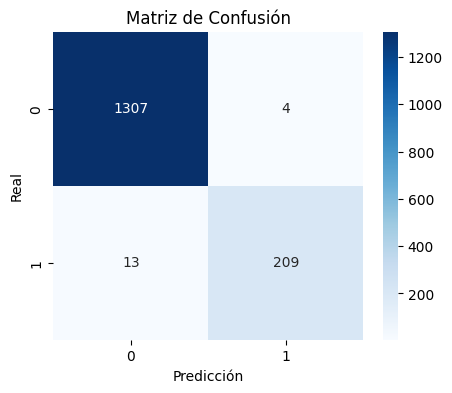

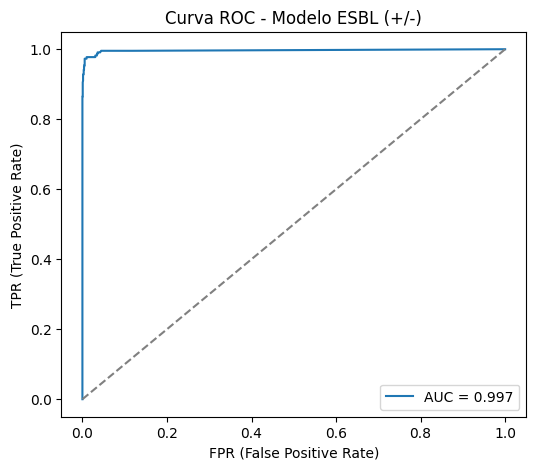

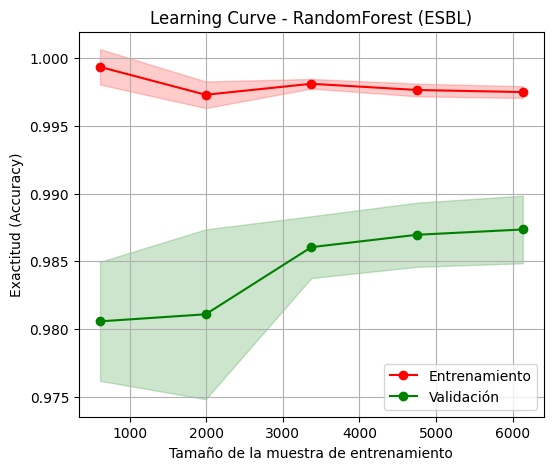


=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===
FEP_NM    0.399688
CRO_NM    0.204139
CAZ_NM    0.190754
CIP_NM    0.052392
SAM_NM    0.028725
CEP_NM    0.022994
AMK_NM    0.016781
TZP_NM    0.012831
AMP_NM    0.010450
NOR_NM    0.009208
NIT_NM    0.009026
CTX_NM    0.008471
ETP_NM    0.008359
GEN_NM    0.005722
CXA_NM    0.005489
CXM_NM    0.005243
MEM_NM    0.004971
FOS_NM    0.004755
dtype: float64


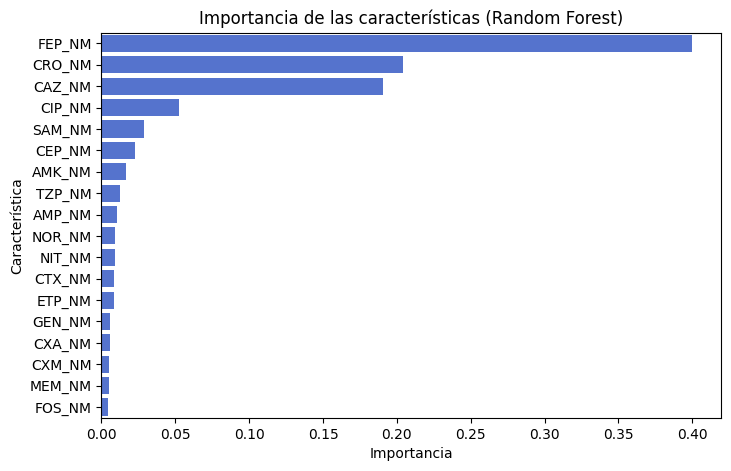


=== EJECUCIÓN TERMINADA ===


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

##############################################################################
# 1. LECTURA DE DATOS
##############################################################################

excel_file = "datos_ecoli.xlsx"  # Ajusta nombre/ruta según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)  # Lee la primera hoja (sheet=0)

print("\n=== Columnas originales ===")
print(df.columns.tolist())

##############################################################################
# 2. ARREGLAR EL NOMBRE DE LAS COLUMNAS
# (Quitar cosas como ',C,10' o ',D' que van tras la primera coma)
##############################################################################

# Creamos nuevos nombres de columnas tomando SOLO lo previo a la primera coma
new_col_names = []
for col in df.columns:
    # Dividir la cadena por la primera coma y quedarse con la primera parte
    clean_name = col.split(',', 1)[0]
    new_col_names.append(clean_name)

df.columns = new_col_names

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())

##############################################################################
# 3. FUNCIÓN PARA PARSEAR VALORES MIC (opcional)
#    Si tienes datos como '<=2', '>16', etc., conviértelos a un valor numérico.
##############################################################################

def parse_mic(value):
    """
    Convierte valores con símbolos <= o > a un número flotante.
    Ejemplo: '<=2' -> 2.0, '>16' -> 32.0
    Ajusta la lógica según tus cortes y criterio de laboratorio.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        try:
            return float(val_str.replace('<=',''))
        except:
            return np.nan
    elif val_str.startswith('>'):
        try:
            base = float(val_str.replace('>',''))
            # Ejemplo: multiplicar por 2 para marcar que está por encima
            return base * 2
        except:
            return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

##############################################################################
# 4. SELECCIONAR COLUMNAS DE INTERÉS (las mencionadas)
##############################################################################

cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

# Ver cuáles de esas columnas existen en el DataFrame limpio
cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")

# (Opcional) Parsear dichas columnas si tienen el formato <=, >
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic)

##############################################################################
# 5. PREPARAR VARIABLE OBJETIVO (ESBL) => binaria
##############################################################################

if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame (ya limpia).")
    
# Convertimos "+"/"-" a 1/0
df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])  # Quita filas donde ESBL_bin sea NaN

##############################################################################
# 6. CONSTRUIR MATRIZ X, y PARA EL MODELO
##############################################################################

X = df[cols_presentes].copy()  # Features
y = df["ESBL_bin"].copy()      # Objetivo

# Rellenar valores faltantes con la media de cada columna (forma sencilla)
X = X.fillna(X.mean())

##############################################################################
# 7. ENTRENAR MODELO (Random Forest) Y EVALUAR
##############################################################################

# Partir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]  # Probabilidades de la clase 1

# Matriz de confusión y reporte de clasificación
cm = confusion_matrix(y_test, y_pred)

print("\n=== MATRIZ DE CONFUSIÓN ===")
print(cm)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))

# Graficar la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Modelo ESBL (+/-)")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.show()

##############################################################################
# 8. LEARNING CURVE (evolución con tamaño de entrenamiento)
##############################################################################

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2, color="r")

plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.2, color="g")

plt.title("Learning Curve - RandomForest (ESBL)")
plt.xlabel("Tamaño de la muestra de entrenamiento")
plt.ylabel("Exactitud (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

##############################################################################
# 9. IMPORTANCIA DE VARIABLES
##############################################################################

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=cols_presentes).sort_values(ascending=False)

print("\n=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===")
print(feat_imp)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp, y=feat_imp.index, color='royalblue')
plt.title("Importancia de las características (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

##############################################################################
# FIN
##############################################################################

print("\n=== EJECUCIÓN TERMINADA ===")


### Serie de tiempo

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_25936\1523255296.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_res = df.resample('M')['CIP_resistant'].mean()  # Promedio (tasa)


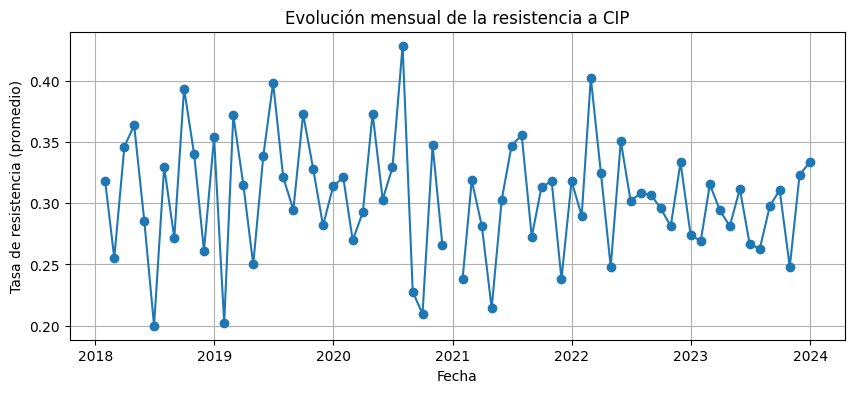

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_25936\1523255296.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_res.fillna(method='ffill', inplace=True)  # rellena NaN


                               SARIMAX Results                                
Dep. Variable:          CIP_resistant   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 118.627
Date:                Thu, 30 Jan 2025   AIC                           -229.254
Time:                        00:23:37   BIC                           -220.148
Sample:                    01-31-2018   HQIC                          -225.629
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3039      0.004     71.840      0.000       0.296       0.312
ar.L1          0.2695      0.524      0.514      0.607      -0.758       1.297
ma.L1         -0.4481      0.468     -0.958      0.3

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Usando el mismo df, asumimos que ya está con nombres limpios
# Asegúrate de que 'SPEC_DATE' sea un tipo fecha:
df['SPEC_DATE'] = pd.to_datetime(df['SPEC_DATE'], errors='coerce')

# Crear una columna binaria: CIP_resistant
# (Ejemplo de punto de corte CIP: 1 mg/L, ajusta según guías)
cutoff_cip = 1.0
df['CIP_resistant'] = (df['CIP_NM'] > cutoff_cip).astype(int)

# Agrupar por mes y calcular la tasa de resistencia
df.set_index('SPEC_DATE', inplace=True)  # Convertir date en índice (facilita resample)
monthly_res = df.resample('M')['CIP_resistant'].mean()  # Promedio (tasa)

# Graficar esa serie
plt.figure(figsize=(10,4))
plt.plot(monthly_res.index, monthly_res.values, marker='o')
plt.title("Evolución mensual de la resistencia a CIP")
plt.xlabel("Fecha")
plt.ylabel("Tasa de resistencia (promedio)")
plt.grid(True)
plt.show()

# Modelo ARIMA (simple) con statsmodels
# (Necesita una serie univariada y un índice de tiempo)
monthly_res.fillna(method='ffill', inplace=True)  # rellena NaN
model = sm.tsa.ARIMA(monthly_res, order=(1,0,1))  # ARIMA(p,d,q)
results = model.fit()
print(results.summary())

# Predecir los próximos 3 meses, por ejemplo
forecast = results.get_forecast(steps=3)
print("\n=== Pronóstico 3 meses ===")
print(forecast.summary_frame())


## Serie de tiempo

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) Revisar cuántos datos válidos hay en cada columna (excepto 'SPEC_DATE', 'ESBL', etc.)
#    Ajusta la lista "posibles_cols" si quieres filtrar solo entre ciertas columnas.
posibles_cols = [col for col in df.columns if col.endswith("_NM") and col not in ["ESBL", "ESBL_bin"]]

conteo_no_nulos = df[posibles_cols].notnull().sum()
top5 = conteo_no_nulos.sort_values(ascending=False).head(5).index.tolist()

print("Las 5 columnas con más datos son:", top5)


Las 5 columnas con más datos son: ['SAM_NM', 'CIP_NM', 'MEM_NM', 'CAZ_NM', 'AMK_NM']


In [30]:
print(df.columns)

Index(['PATIENT_ID', 'SEX', 'DATE_BIRTH', 'AGE', 'WARD', 'SPEC_TYPE',
       'ORGANISM', 'ESBL', 'CARBAPENEM', 'X_IAD',
       ...
       'MUP_ND5', 'PEN_ND10', 'RIF_ND5', 'STH_ND300', 'TCY_ND30', 'TEC_ND30',
       'TGC_ND15', 'X_1_NM', 'ESBL_bin', 'CIP_resistant'],
      dtype='object', length=143)


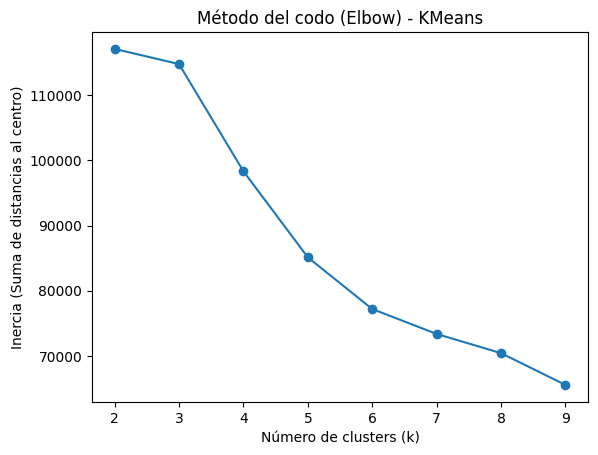

cluster
2    4239
0    3420
1       6
Name: count, dtype: int64


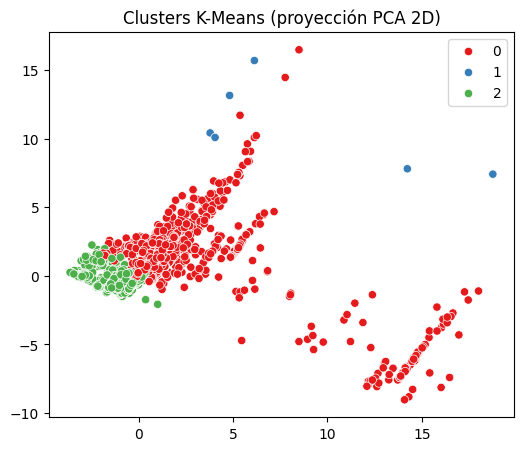

In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo df ya limpio, con las columnas MIC:
X = df[cols_presentes].copy()  # Reutilizar la lista 'cols_presentes'
X = X.fillna(X.mean())

# Opcional: Normalizar datos (MIC varía en rangos distintos)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elegir número de clusters (k). Podemos usar la "técnica del codo" o "silhouette".
inertias = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title("Método del codo (Elbow) - KMeans")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de distancias al centro)")
plt.show()

# Supongamos elegimos k=3
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(X_scaled)

df['cluster'] = labels  # asignamos el cluster a cada muestra

# Análisis: ver cuántas muestras hay en cada cluster
print(df['cluster'].value_counts())

# Graficar alguna proyección con PCA 2D para visualizar clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=coords_2d[:,0], y=coords_2d[:,1], hue=labels, palette="Set1")
plt.title("Clusters K-Means (proyección PCA 2D)")
plt.show()
